# Support-Vector Klassifikation

## Überblick

Wir versuchen Datensätze durch Hyperebenen in Cluster einzuteilen.
Die Aufgabenstellung führt zu konvexen Optimierungsproblemen mit
Ungleichheitsnebenbedingungen.

Anschließend wird der Ansatz so erweitert (Kernel-Trick), dass
komplexere trennende Hyperflächen benutzt werden können.

## Grundlagen

Gegeben sind Daten $x_i \in \mathbb{R}^m$, $y_i\in \{-1,1\}$,
$i=1,\ldots,n$. Die Daten setzen sich aus zwei Gruppen zusammen, die durch ihre
diskreten $y_i$-Werte unterschieden werden.
Ohne Einschränkung nehmen wir $y_i = \pm 1$ an.

Gesucht ist eine Hyperebene $H$, die die beiden Gruppen trennt,
d.h. alle Punkte mit $y_i=-1$ liegen auf der einen Seite von $H$,
alle mit $y_i=1$ liegen auf der anderen Seite.
Diese Hyperebene wird dann zur Vorhersage der Gruppenzugehörigkeit eines neuen Wertes $x$ benutzt.
Je nachdem auf welcher Seite der Hyperebene (d.h. in welchem Halbraum) der Wert $x$ liegt, wird $y=-1$ bzw. $y=1$ als Vorhersage geliefert.

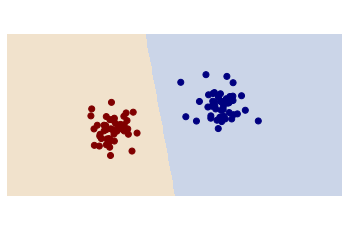

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn import svm
from sklearn.datasets import make_blobs

def plotXy(X, y, alpha = 1.0, marker = 'o', axis = 'off', equal = True):
    ax = plt.gca()
    ax.scatter(*X.T, c = y, cmap = plt.cm.jet, alpha = alpha, marker = marker)
    
    if equal:
        ax.axis('equal')
    ax.axis(axis)
    
def plotf(f, X, nh = 400, nc = 1, umgebung = 2.0):
    # Gitter für contourf
    Xmin = X.min(axis=0)
    Xmax = X.max(axis=0)
    
    Xm = 0.5 * (Xmin + Xmax)
    Xmin = Xm - umgebung *(Xm - Xmin)
    Xmax = Xm + umgebung *(Xmax - Xm)
    
    hx = np.linspace(Xmin[0], Xmax[0], nh)
    hy = np.linspace(Xmin[1], Xmax[1], nh)

    yy, xx = np.meshgrid(hy, hx)
    
    # Konturplot
    plt.contourf(xx, yy, f(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape), nc, cmap = plt.cm.Pastel2)
   
    plt.axis('equal')
    plt.axis('off')

def plotH(X, y, nh = 400, nc = 1, umgebung = 2.0):
    # SVM
    svc = svm.SVC(C = np.finfo(float).max, kernel = 'linear')
    svc.fit(X, y)
    
    # Ebene
    plotf(svc.predict, X, nh, nc, umgebung)
    # Datenpunkte
    plotXy(X, y)

    plt.axis('equal')
    plt.axis('off')

X,y = make_blobs(n_features=2, centers=2, random_state=17)
X[:,[0,1]] = X[:,[1,0]]
y = 2*y - 1

plotH(X, y)

## Vorüberlegungen

Bei zwei Datenpunkten mit $y_1=-1$ und $y_2=1$ kann man als Hyperebene
$H$ z.B. die Ebene wählen, die senkrecht auf der Verbindungslinie
der beiden Punkte steht.

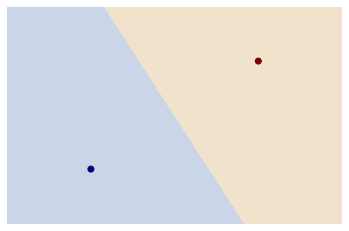

In [2]:
np.random.seed(31415)
X2 = np.random.rand(2,2)
y2 = np.array([-1,1])

plotH(X2, y2)

Offensichtlich ist das nicht die einzige trennende Hyperebene, allerdings besitzt sie eine Extremaleigenschaft.
Unter allen trennenden Hyperebenen ist sie diejenige, die den größten (Minimal)Abstand zu den beiden Datenpunkten hat.
Andererseits gibt es einfache Situationen, in denen die optimale Hyperebene
nicht die Mittelsenkrechte zwischen Datenpunkten ist bzw. gar keine
trennende Hyperebene existiert, wie die folgenden beiden Beispiele zeigen.

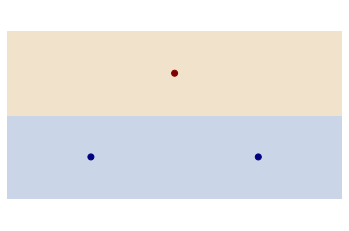

In [3]:
Xnomi = np.array([[0,0], [2,0], [1,1]])
ynomi = np.array([-1, -1, 1])
plotH(Xnomi, ynomi)

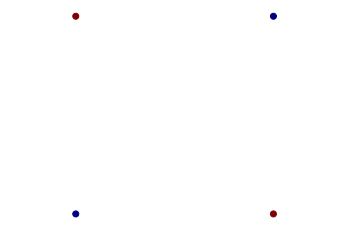

In [4]:
Xno = np.array([[0,0], [1,1], [0,1], [1,0]])
yno = np.array([-1, -1, 1, 1])
plotXy(Xno, yno)

Diesen Fall werden wir später gesondert behandeln.

Wir nehmen zunächst an, dass für unseren Datensatz immer (mindestens) eine trennende Hyperebene existiert.
Auch wenn der Datensatz mehr als einen Punkt pro Klasse enthält
kann es natürlich viele verschiedene trennende Hyperebenen geben.
Wir suchen wieder diejenige aus, die zu den Datenpunkten beider
Klassen den größten Minimalabstand hat.

## Hyperebenen

Mathematisch kann man eine Hyperebene in $\mathbb{R}^m$ durch
\begin{equation*} 
H(w) = \{ x \ |\ x\in \mathbb{R}^m, \ g(x, w) = 0\},
\end{equation*}
mit
\begin{align*} 
g(x, w) &= v^T x - v_0, \\
w &= (v, v_0), \\
v &\in\mathbb{R}^m \setminus \{0\},\\
v_0 &\in \mathbb{R}
\end{align*} 
beschreiben (*Normalform*).
Die Parameter $v$, $v_0$ haben eine geometrische Bedeutung:

- $v$ ist ein Vektor, der senkrecht auf $H(w)$ steht

- ist zusätzlich $\|v\|_2=1$ dann gilt:

    - $|v_0|$ ist der Abstand von $H(w)$ zum Ursprung.
    
    - für $x \in \mathbb{R}^m$ gibt $g(x,w)$ den vorzeichenbehafteten Abstand des Punktes $x$ zu $H(w)$ an.
    
    - bei positiven Werten für $g(x,w)$ liegt $x$ auf der Seite
      von $H(w)$ in die $v$ zeigt, bei negativen Werten von $g(x,w)$ auf der anderen.

Die selbe Hyperebene kann durch verschiedene Parameter beschrieben werden, denn
\begin{equation*} 
H(w) = H(\tilde{w}) \quad\Leftrightarrow\quad w = \lambda \tilde{w},
\quad  \lambda\in\mathbb{R}\setminus\{0\}.
\end{equation*}

Man kann also die Parameter immer so wählen, dass $\|v\|_2=1$, womit $v, v_0$
bis auf das Vorzeichen eindeutig festgelegt sind.
Außerdem kann man für beliebiges $\mathbb{R} \ni M > 0$ 
für jede Hyperebene $H$ Parameter $v$, $v_0$
finden mit
\begin{equation*} 
H = H(w), \quad w = (v, v_0), \quad M\, \|v\|_2 = 1.
\end{equation*}

## Optimal trennende Hyperebenen

Für unseren Datensatz nehmen wir an, dass es trennende Hyperebenen gibt, d.h. es gibt ein $w$ so dass für
\begin{align*} 
H(w) &= \{ x \ |\ x\in \mathbb{R}^m, \ g(x,w) = 0\},
\\
g(x,w) &= v^T x + v_0,
\\
w &= (v, v_0),
\end{align*}
alle Daten $x_i$ mit $y = -1$ auf der einen und alle  mit $y = 1$ auf der anderen Seite liegen.
Daraus folgt, dass
\begin{equation*} 
g(x_i, w) > 0 \text{ für } y_i = 1,
\quad
g(x_i, w) < 0 \text{ für } y_i = -1
\end{equation*}
und somit gibt
\begin{equation*} 
d_i = y_i \, g(x_i, w)
\end{equation*}
den positiven Abstand des Datenpunkts $x_i$ zur Hyperebene an.
Ist nun 
\begin{equation*} 
d_i = y_i \: g(x_i, w) \geq M > 0 \quad \forall i,
\end{equation*} 
dann haben alle Datenpunkte einen Mindestabstand $M>0$ von 
$H(w)$.

Jede Hyperebene $H$ mit $y_ig(x_i, w) \geq M > 0$ $\forall i$
ist eine trennende, denn $g(x_i, w)$ nimmt für $y_i = \pm 1$ positive bzw. negative Werte an, d.h. die entsprechenden $x_i$ liegen auf verschiedenen Seiten von $H$.

Die optimal trennende Hyperebene ist also diejenige Hyperebene,
für die für $M$ der größte Wert benutzt werden kann.
Insgesamt erhalten wir also folgendes Optimierungsproblem:

Bestimme $w=(v,v_0)$, $v\in\mathbb{R}^m$ mit $\|v\|_2=1$, $v_0 \in \mathbb{R}$ so, dass 
\begin{equation*} 
y_i g(x_i, w) = y_i (v^T x_i + v_0) \geq M, \quad i = 1,\ldots,n
\end{equation*}
für möglichst großes $M>0$, also
\begin{equation*} 
\max_{w=(v,v_0),\|v\|_2=1} M(w)
\end{equation*}
mit
\begin{equation*} 
y_i(v^T x_i + v_0) \geq M(w) > 0, 
\quad i = 1,\ldots,n.
\end{equation*}
  
Es handelt sich also um ein Optimierungsproblem mit Ungleichheitsnebenbedingungen.
Hat man dieses Problem gelöst, so können neue Datenpunkte $X$ durch
\begin{equation*} 
y 
= \text{sign}\big(g(x,w)\big) 
= \text{sign}\big(v^T x + v_0\big)
\end{equation*}
einem der beiden durch die optimale
Hyperebene separierten Cluster (also $y = \pm1$)
zugeordnet werden.

## Umformulierung des Optimierungsproblems

In der bisherigen Form ist das Optimierungsproblem sehr unübersichtlich.
Deswegen werden wir es in eine neue Form bringen.

Die Nebenbedingung $\|v\|_2=1$ kann relativ einfach beseitigt werden.
Hat die optimale Hyperebene die Parameter $\hat{v}$, $\hat{v}_0$,
$\|\hat{v}\|_2=1$, mit zugehörigem Minimalabstand $\hat{M}$, dann definiert
der Parametersatz $w = \lambda\hat{w}$ für 
alle $\lambda \neq 0$ die selbe Hyperebene.

Ist nun $v\neq 0$, $v_0$ ein beliebiger Parametersatz mit
\begin{equation*} 
\frac{1}{\|v\|_2} y_i(v^T x_i + v_0) \geq \hat{M}, \quad i = 1,\ldots,n,
\end{equation*}
dann ist $\frac{1}{\|v\|_2} v$, $\frac{1}{\|v\|_2} v_0$
Lösung unseres Optimierungsproblems.
Damit können wir das Optimierungsproblem umschreiben:

Bestimme $w = (v,v_0)$, $0\neq v\in\mathbb{R}^m$, $v_0 \in \mathbb{R}$ mit
\begin{equation*} 
\max_{v\neq 0, v_0} M(w),
\quad
y_i(v^T x_i + v_0) \geq M(w) \ \|v\|_2, \quad i = 1,\ldots,n.
\end{equation*}

Da wir die Länge des Koeffizientenvektors $v$ beliebig skalieren können, können wir
die Skalierung so wählen, dass
\begin{equation*} 
M(w) \ \|v\|_2 = 1
\end{equation*}
ist, d.h. insbesondere ist dann
\begin{equation*} 
M(w) = \frac{1}{\|v\|_2}.
\end{equation*}
Somit erhalten wir als neues Problem:

Bestimme $w = (v,v_0)$,  $0\neq v\in\mathbb{R}^m$, $v_0 \in \mathbb{R}$ mit
\begin{equation*} 
\max_{v\neq 0, v_0} \frac{1}{\|v\|_2}
\quad\text{mit}\quad
y_i(v^T x_i + v_0) \geq 1, \quad i = 1,\ldots,n.
\end{equation*}

Benutzt man jetzt noch, dass die Maximalstellen von $\frac{1}{\|v\|_2}$ identisch sind mit den
Minimalstellen von $\frac{1}{2}\|v\|_2^2$, dann erhalten wir die finale Form unseres Problems:

Bestimme $w = (v,v_0)$, $0\neq v\in\mathbb{R}^m$, $v_0 \in \mathbb{R}$ mit
\begin{equation*} 
\min_{v\neq 0, v_0} \frac{1}{2}\|v\|_2^2
\quad\text{mit}\quad
y_i(v^T x_i + v_0) - 1 \geq 0, \quad i = 1,\ldots,n.
\end{equation*}

Dies ist ein konvexes Optimierungsproblem mit Ungleichheitsnebenbedingungen.

## Restringierte Optimierung

Zur Bestimmung der optimal trennenden Hyperebene müssen wir die konvexe Funktion
$\frac{1}{2}\|v\|_2^2$ über dem konvexen Gebiet, das in $\mathbb{R}^{n+1}$
durch die Ungleichheitsnebenbedingungen 
\begin{equation*} 
y_i(v^T x_i + v_0) - 1 \geq 0, \quad i = 1,\ldots,n
\end{equation*}
festgelegt wird, minimieren.

Probleme dieser Art führt man mit Hilfe der Lagrange-Funktion
auf nicht restringierte Probleme zurück.
Die Lagrange-Funktion ist in unserem Fall gegeben durch
\begin{equation*} 
L(v,v_0, \alpha) = \frac{1}{2}\|v\|_2^2 - \sum_{i=1}^n \alpha_i \big(y_i(v^T x_i + v_0) - 1 \big).
\end{equation*}
$\mathbb{R}\ni\alpha_i$ sind die sogenannten Lagrange-Multiplikatoren. Wir "hängen" also die Nebenbedingungen einfach über die Lagrange-Multiplikatoren an die zu minimierende Zielfunktion $\frac{1}{2}\|v\|_2^2$ an.

Ein Ergebnis aus der Analysis ([Karush-Kuhn-Tucker-Bedingungen](https://de.wikipedia.org/wiki/Karush-Kuhn-Tucker-Bedingungen), KKT) besagt, dass (unter gewissen Regularitätsvoraussetzungen)
für ein Minimum $\hat{v}, \hat{v}_0$ Parameter 
$\hat{\alpha}_i\geq 0$ existieren, so dass
folgende notwendigen Bedingungen gelten:

- für die partiellen Ableitungen von $L$ nach den 
  Komponenten von $v$ und nach $v_0$ ist
  \begin{equation*} 
  \partial_{v_k} L(\hat{v},\hat{v}_0, \hat{\alpha}) = 0, \quad k=0,\ldots,m.
  \end{equation*}
  
- die Nebenbedingungen sind erfüllt sein:
  \begin{equation*} 
  y_i(\hat{v}^T x_i + \hat{v}_0) - 1 \geq 0, \quad i=1,\ldots,n.
  \end{equation*}
  
- Komplementaritätsbedingung:
  \begin{equation*} 
  \hat{\alpha}_i\big(y_i(\hat{v}^T x_i + \hat{v}_0) - 1\big) = 0, \quad i=1,\ldots,n.
  \end{equation*}
  


Wegen
\begin{equation*} 
L(v,v_0, \alpha) 
= \frac{1}{2} \sum_{i=1}^m v_i^2 - \sum_{i=1}^n \alpha_i  \Big(y_i \big(\sum_{j=1}^m v_j x_{ij} + v_0 \big) - 1 \Big)
\end{equation*}
erhält man für die partiellen Ableitungen
\begin{align*}
\partial_{v_0} L(v,v_0, \alpha)
&= - \sum_{i=1}^n \alpha_i y_i \\
\partial_{v_k} L(v,v_0, \alpha)
&= 
v_k
- \sum_{i=1}^n \alpha_i y_i x_{ik},
\quad k = 1,\ldots,n.
\end{align*}

Für die optimalen Parameter $\hat{v}, \hat{v}_0$ muss also
\begin{align*}
0
&=
\sum_{i=1}^n \hat{\alpha}_i y_i, 
\\
\hat{v} &= \sum_{i=1}^n \hat{\alpha}_i y_i x_i
\end{align*}
gelten, sowie
\begin{align*}
\hat{\alpha}_i 
&\geq 0,
\\
y_i(\hat{v}^T x_i + \hat{v}_0) - 1 
&\geq 0,
\\ 
\hat{\alpha}_i\big(y_i(\hat{v}^T x_i + \hat{v}_0) - 1\big) 
&= 0
\end{align*}
für alle $i=1,\ldots,n$.

Daraus können wir nun schlussfolgern:

- $\hat{v}$ ist eine Linearkombination der Produkte $y_ix_i$ aus den Input-Daten, d.h. ist $\hat{\alpha}_i=0$
  dann hat $x_i, y_i$ keinen Einfluss auf $\hat{v}$.

- ist $\hat{\alpha}_i > 0$ dann muss wegen der letzten Bedingung
  \begin{equation*} 
  y_i(\hat{v}^T x_i + \hat{v}_0) - 1 = 0
  \end{equation*} 
  sein, d.h. der Datenpunkt $x_i$ hat den minimalen Abstand zur Hyperebene, er liegt
  also damit auf der "Front" seines Clusters.

- ist $y_i(\hat{v}^T x_i + \hat{v}_0) - 1 > 0$, d.h.
  der Abstand von $x_i$ zur Hyperebene ist nicht minimal, 
  so muss wegen der letzten Bedingung $\hat{\alpha}_i = 0$ sein,
  somit hat der Datenpunkt $x_i, y_i$ keinen Einfluss auf den
  optimalen Parameter $\hat{v}$.

- da $\hat{v} \neq 0$ ist, muss es mindestens einen
  Index $\hat{i}$ mit $\hat{\alpha}_{\hat{i}}>0$ geben.

- aus der letzten Bedingung von oben folgt dann aber
  \begin{equation*} 
  y_{\hat{i}}(\hat{v}^T x_{\hat{i}} + \hat{v}_0) - 1 = 0
  \end{equation*}
  also
  \begin{equation*} 
  \hat{v}_0 
  = \frac{1}{y_{\hat{i}}} - \hat{v}^T x_{\hat{i}}
  = y_{\hat{i}} - \hat{v}^T x_{\hat{i}} 
  \end{equation*}
  und somit ist auch $\hat{v}_0$ unabhängig von
  Punkten $x_i, y_i$, für die $\hat{\alpha}_i = 0$
  ist, also insbesondere für die, 
  die keinen Minimalabstand zur Hyperebene haben.

- für die Vorhersage der Clusterzugehörigkeit von neuen
  Input-Daten $x$ benutzen wir
  \begin{equation*} 
  y = \text{sign}(\hat{f}(x)),
  \quad
  \hat{f}(x) = \hat{v}^T x + \hat{v}_0
  \end{equation*}
  also
  \begin{equation*} 
  \hat{f}(x) 
  = \hat{v}^T x + y_{\hat{i}} - \hat{v}^T x_{\hat{i}} 
  = y_{\hat{i}} + \hat{v}^T \big( x - x_{\hat{i}} \big)
  \end{equation*}
  mit 
  \begin{equation*} 
  \hat{v} = \sum_{\hat{\alpha}_i>0} \hat{\alpha}_i y_i x_i,
  \end{equation*}
  d.h. das Modell wird ausschließlich durch die Datenpunkte $x_i,y_i$
  bestimmt, die minimalen Abstand zur optimalen Hyperebene haben.

Die Datenpunkte $x_i$ die auf der "Front" beider Cluster
liegen ($\hat{\alpha}_i > 0$) werden **Support Punkte** genannt,
das zugehörige Klassifikationsverfahren bezeichnet
man als **Support Vector Classification**.

Da für die Vorhersage nur Support Points benutzt werden, ist diese
auch bei großen Datensätzen mit wenig Aufwand verbunden.

## Beispiel

In Scikit-Learn kann man trennende Hyperebenen 
mit Objekten der Klasse `SVC` (mit Parameter `C = np.finfo(float).max`,
`kernel = 'linear'`) erzeugen. Wir benutzen den Datensatz von oben und fitten unser Modell.

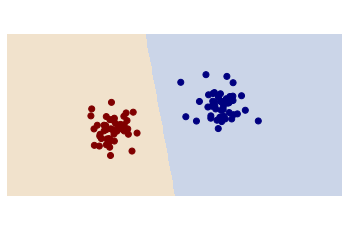

In [5]:
X,y = make_blobs(n_features=2, centers=2, random_state=17)
X[:,[0,1]] = X[:,[1,0]]
y = 2*y - 1

svc = svm.SVC(C = np.finfo(float).max, kernel = 'linear')
svc.fit(X, y)

plotf(svc.predict, X)
plotXy(X,y)

Mit `svc.score` können wir zunächst überprüfen, ob
wirklich eine trennende Hyperebene für unseren Datensatz
gefunden wurde (score = 1).

In [6]:
svc.score(X,y)

1.0

Für diesen Datensatz ist also alles in Ordnung.

Mit `svc.n_support_` kann abgefragt werden, wie viele Support Punkte pro Klasse existieren.
Der erste Wert gibt die Anzahl der Support Punkte in der Klasse 
$y=-1$, der zweite Wert die Anzahl der Support Punkte in der Klasse 
$y=1$ an.

`svc.support_` liefert die Indizes der Support Punkte bezogen auf den Input-Datensatz.

In [7]:
svc.n_support_, svc.support_

(array([1, 2], dtype=int32), array([78, 27, 74], dtype=int32))

Die zugehörigen Datenpunkte sind in der folgenden Abbildungen rot markiert.

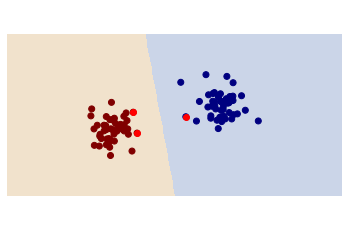

In [8]:
plotf(svc.predict, X)
plotXy(X,y)
plt.plot(*svc.support_vectors_.T, 'ro');

Die Parameter $\hat{v}$, $\hat{v}_0$ sind in 
`svc.coef_` bzw. `svc.intercept_` zu finden

In [9]:
svc.coef_, svc.intercept_

(array([[-0.44426779, -0.08195204]]), array([-2.44497832]))

Die Werte $\hat{\alpha}_iy_i \neq 0$, die in
\begin{equation*} 
\hat{v} = \sum_{\hat{\alpha}_i>0} \hat{\alpha}_i y_i x_i,
\end{equation*}
eingehen, sind in `svc.dual_coef_` abgelegt.

In [10]:
svc.dual_coef_

array([[-0.10200703,  0.06731152,  0.03469552]])

Mit `svc.decision_function` kann man schließlich den Abstand eines Input-Wertes von der trennenden
Hyperebene ermitteln. Für die Support Punkte erhalten wir

In [11]:
svc.decision_function(X[svc.support_])

array([-1.00049625,  1.0002484 ,  1.00024794])

Die Werte sind nicht identisch, liegen aber innerhalb der von SVC vorgegebenen Standardtoleranz (1e-3).

## Überlappende Cluster

Bisher sind wir davon ausgegangen, dass die Daten $x,y$ so strukturiert sind,
dass eine trennende Hyperebene existiert. In der Praxis wird das selten der Fall sein.
Deshalb wollen wir den Zugang aus dem letzten Abschnitt auf "überlappende" Daten erweitern.
Dazu betrachten wir folgenden Datensatz.

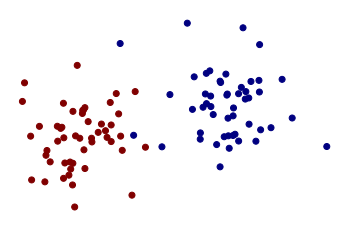

In [12]:
X,y = make_blobs(n_features=2, centers=2, cluster_std=2, random_state=17)
X[:,[0,1]] = X[:,[1,0]]
y = 2*y - 1

plotXy(X, y)

Für nicht überlappende Cluster hatten wir die optimal trennende Hyperebene durch Lösen von
\begin{equation*} 
\min_{v\neq 0, v_0} \frac{1}{2}\|v\|_2^2 \quad\text{mit}\quad
y_i(v^T x_i + v_0) - 1 \geq 0, \quad i = 1,\ldots,n
\end{equation*}
bestimmt. Die über die Lösung $\hat{v}, \hat{v}_0$ definierte Hyperebene hatte
dann von allen Punkten *beider* Cluster einen Mindestabstand von
\begin{equation*} 
\hat{M} = \frac{1}{\|\hat{v}\|_2},
\end{equation*}
d.h.
\begin{equation*} 
\hat{d}_i 
= y_i 
\big( 
\frac{\hat{v}^T}{\|\hat{v}\|_2} x_i 
+ \frac{\hat{v}_0}{\|\hat{v}\|_2}
\big) 
\geq \hat{M}, 
\quad i = 1,\ldots,n.
\end{equation*}

Für überlappende Cluster kann man diese Nebenbedingung nicht einhalten.
Um trotzdem eine "pseudo-trennende" Hyperebene zu definieren, müssen wir Fehler zulassen,
d.h. wir müssen die Nebenbedingung abschwächen zu
\begin{equation*} 
d_i 
= y_i \frac{1}{\|v\|_2}(v^T x_i + v_0) 
\geq M (1 - \xi_i), 
\quad 
i = 1,\ldots,n
.
\end{equation*}
Dabei stellt $\xi_i \geq 0$ den "relativen Fehler" für den Datenpunkt $x_i$ dar.

Für $0 < \xi_i < 1$ liegt $x_i$ zwar auf der richtigen Seite der Hyperebene, hat aber einen Abstand
kleiner $M$.

Für $\xi_i > 1$ liegt $x_i$ auf der "falschen" Seite der Hyperebene, d.h. $x_i$
würde bei der Vorhersage dem falschen Cluster zugeordnet (**Misclassification**).

Durch die Zusatzbedingung
\begin{equation*} 
\sum_{i=1}^n \xi_i \leq K
\end{equation*}
kann man somit die maximale Anzahl an Missklassifikationen auf maximal $K \in \mathbb{N}$ beschränken.

Analog zu oben formuliert man das
[Optimierungsproblem](http://docs.w3cub.com/scikit_learn/modules/svm/#svm-mathematical-formulation)
um zu
\begin{equation*} 
\min_{v\neq 0, v_0,\xi}
\Big(
\frac{1}{2}\|v\|_2^2
+ C \sum_{i=1}^n \xi_i
\Big)
\end{equation*}
mit
\begin{equation*} 
\xi_i\geq 0,
\quad
y_i(v^T x_i + v_0)  \geq 1 - \xi_i, \quad i = 1,\ldots,n.
\end{equation*}
Statt die maximale Anzahl $K$ an Missklassifikationen zu benutzen
gewichtet man die Fehlersumme hier mit $C>0$.

Für $C\to\infty$ muss dann die Summe der Fehler verschwinden,
d.h. man erhält (wenn das Problem dann überhaupt lösbar ist)
den Fall der optimal separierenden Hyperebene.

Für $C\to 0$ dürfen die Fehler beliebig groß werden,
so dass sicher eine Lösung des Problems existiert.

Für die Lagrange-Funktion erhalten wir jetzt
\begin{align*} 
L(v, v_0, \xi, \alpha, \beta) 
= &\Big(
\frac{1}{2}\|v\|_2^2
+ C \sum_{i=1}^n \xi_i
\Big)
\\
&- \sum_{i=1}^n \alpha_i  \Big(y_i \big(\sum_{j=1}^m v_j x_{ij} + v_0 \big) - 1 + \xi_i \Big)\\
&- \sum_{i=1}^n\beta_i \xi_i
\end{align*}
mit den partiellen Ableitungen
\begin{align*}
\partial_{v_0} L(v, v_0, \xi, \alpha, \beta) 
&= - \sum_{i=1}^n \alpha_i y_i, \\
\partial_{v_k} L(v, v_0, \xi, \alpha, \beta) 
&= 
v_k
- \sum_{i=1}^n \alpha_i y_i x_{ik},
\quad k = 1,\ldots,m.
\\
\partial_{\xi_i} L(v, v_0, \xi, \alpha, \beta) 
&= 
C - \alpha_i - \beta_i,
\quad i = 1,\ldots,n.
\end{align*}

Für die optimalen Parameter $\hat{v}, \hat{v}_0, \hat{\xi}$ muss also
\begin{align*}
0
&=
\sum_{i=1}^n \hat{\alpha}_i y_i, 
\\
\hat{v} &= \sum_{i=1}^n \hat{\alpha}_i y_i x_i\\
\hat{\alpha}_i &= C - \hat{\beta}_i
\end{align*}
gelten, sowie
\begin{align*}
\hat{\alpha}_i 
&\geq 0,
\\
y_i(\hat{v}^T x_i + \hat{v}_0) - 1 + \hat{\xi}_i
&\geq 0,
\\ 
\hat{\alpha}_i\big(y_i(\hat{v}^T x_i + \hat{v}_0) - 1 + \hat{\xi}_i \big) 
&= 0\\
\hat{\beta}_i 
&\geq 0,
\\
\hat{\xi}_i
&\geq 0,
\\ 
\hat{\beta}_i \hat{\xi}_i 
&= 0
\end{align*}
für alle $i=1,\ldots,n$.

Daraus können wir nun wieder schlussfolgern, dass nur Support Punkte mit 
\begin{equation*} 
y_i(\hat{v}^T x_i + \hat{v}_0) - (1 - \hat{\xi}_i) = 0
\end{equation*}
in das Modell einfließen.

Wir berechnen nun für unseren Beispieldatensatz von oben für verschiedene Werte von $C$ die Hyperebene und
die zugehörigen Support Punkte.

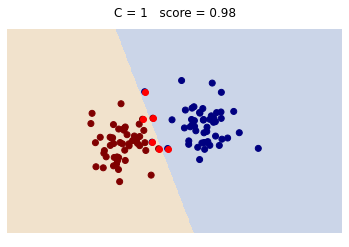

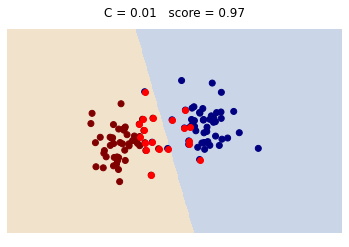

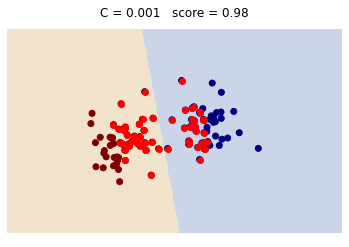

In [13]:
#plotXy(X, y)

for C in [1, 1e-2, 1e-3]:
    plt.figure()
    plotXy(X, y)

    svc = svm.SVC(C = C, kernel = 'linear')
    svc.fit(X, y)

    plotf(svc.predict, X)
    plotXy(X,y)
    plt.plot(*svc.support_vectors_.T, 'ro')
    plt.title("C = {}   score = {}".format(C, svc.score(X,y)));

## Dimensionserhöhung, Kernel-Trick

### Grundlagen

Wir betrachten den folgenden Datensatz aus dem sklearn Fundus.

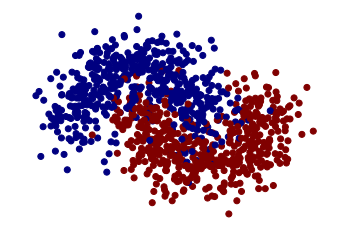

In [14]:
from sklearn.datasets import make_moons

X,y = make_moons(n_samples=1000, noise=0.3, random_state = 0)

plotXy(X, y)

Die beiden Cluster sind ineinander verschränkt, so dass
eine Trennung durch eine Hyperebene keine guten Ergebnisse
liefern wird. Mit dem Standard SVC Zugang erhalten wir das folgende Resultat.

Score = 0.845   Anzahl Support-Punkte = [177 177]

              precision    recall  f1-score   support

           0       0.84      0.85      0.85       500
           1       0.85      0.84      0.84       500

    accuracy                           0.84      1000
   macro avg       0.85      0.84      0.84      1000
weighted avg       0.85      0.84      0.84      1000



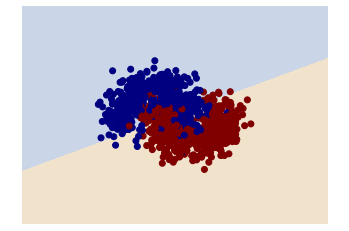

In [15]:
from sklearn import metrics 

svc = svm.SVC(kernel = 'linear')

svc.fit(X, y)

plotf(svc.predict, X)
plotXy(X,y)

print('Score = {}   Anzahl Support-Punkte = {}\n'.format(svc.score(X,y), svc.n_support_))
ypred = svc.predict(X)
print(metrics.classification_report(y, ypred))

Transformieren wir die Daten vom $\mathbb{R}^2$ in 
$\mathbb{R}^m$ mit $m>2$, dann lassen sie
sich dort (eventuell) besser mit einer Hyperebenen trennen.

Wir betrachten hier den Fall $m=3$ und transformieren
die $x$-Werte durch eine Funktion
\begin{equation*} 
\phi : \mathbb{R}^2 \to \mathbb{R}^3,
\quad 
\tilde{x} = \phi(x),
\quad 
\phi(x) =
\frac{\|x\|_2}{1 + \|x\|_2^2}
\begin{pmatrix}
x_1 \\ x_2 \\ 1
\end{pmatrix}
\end{equation*}

<IPython.core.display.Javascript object>


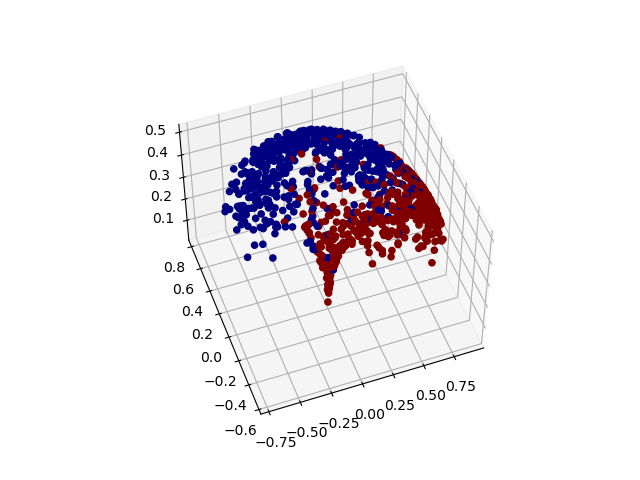

In [16]:
def phis(x):
    s = np.sqrt(x.dot(x))
    w = np.r_[x, 1.0] *  s / (1.0 + s*s)
    return(w)

def phi(x):
    if x.ndim == 1:
        return(phis(x))
    else:
        return(np.array(list(map(phis, x))))

Xt = phi(X)

#%matplotlib inline
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D

plt.axes(projection='3d')
plotXy(Xt, y, axis='on', equal=False)
plt.gca().view_init(50,250)

Wenden wir nun Standard SVC auf den transformierten Datensatz an,
dann erhalten wir einen deutlich verbesserten Score Wert.

In [17]:
%matplotlib inline
svc = svm.SVC(kernel = 'linear')

svc.fit(Xt, y)

print('Score = {}   Anzahl Support-Punkte = {}\n'.format(svc.score(Xt,y), svc.n_support_))
ypred = svc.predict(Xt)
print(metrics.classification_report(y, ypred))

Score = 0.906   Anzahl Support-Punkte = [159 159]

              precision    recall  f1-score   support

           0       0.93      0.88      0.90       500
           1       0.88      0.93      0.91       500

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



Um eine Vorhersage für neue $x$-Werte zu erzeugen
berechnen wir einfach $\tilde{x} = \phi(x)$ und bestimmen
anhand der Hyperebene im höherdimensionalen Raum
die Klassenzugehörigkeit.

<IPython.core.display.Javascript object>


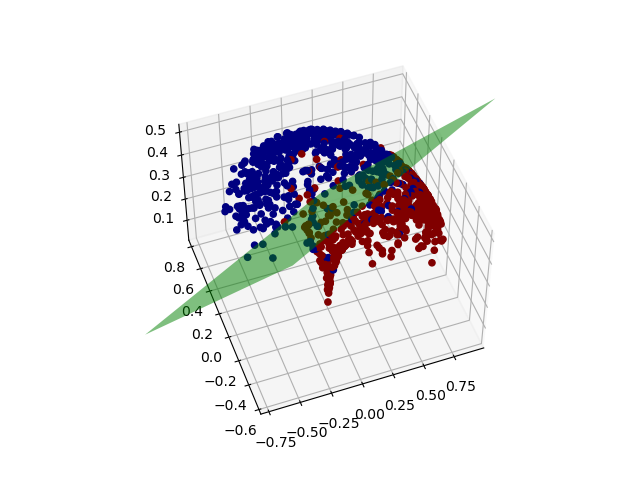

In [18]:
#%matplotlib inline
%matplotlib notebook

from mpl_toolkits.mplot3d.art3d import Poly3DCollection

plt.axes(projection='3d')

plotXy(Xt, y, axis='on', equal=False)

# Support Punkte
plt.plot(*svc.support_vectors_.T, 'r.');

# Hyperebene
beta = svc.coef_[0]
beta0 = svc.intercept_[0]

v0 = -beta0 / beta.dot(beta) * beta
v1 = np.cross([0,0,1], beta)
v1 = v1 / np.linalg.norm(v1, 2)
v2 = np.cross(v1, beta)
v2 = v2 / np.linalg.norm(v2, 2)

ecken = np.c_[-v1-v2, v1-v2, v1+v2, -v1+v2] + np.c_[v0]

# Workaround wegen alpha-Bug
poly = Poly3DCollection([ecken.T], alpha=0.5, facecolor = "g")
plt.gca().add_collection3d(poly)

plt.gca().view_init(50,250)

Damit ergibt sich für die Klassenaufteilung im ursprünglichen $x$-Parameterraum folgendes Bild.

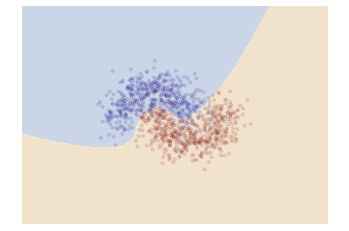

In [19]:
%matplotlib inline

def pred(X):
    return(svc.predict(phi(X)))

plotf(pred, X)
plotXy(X, y, alpha=0.1, marker = '.')

Die Trennlinie der beiden Bereiche ist keine einfache
Gerade mehr, obwohl im höherdimensionalen Raum die Punkte
durch eine Hyperebene getrennt werden.
Dies ist ein Effekt der nichtlinearen Transformation $\phi$.

### Mathematische Formulierung

Der oben beschriebene Zugang kann so in SVC implementiert werden,
dass eine explizite Berechnung von $\tilde{x} = \phi(x)$ nicht
nötig ist.

Dazu betrachten wir das restringierte [Optimierungsproblem](http://docs.w3cub.com/scikit_learn/modules/svm/#svm-mathematical-formulation), das für SVC gelöst wird:
\begin{equation*} 
\min_{v\neq 0, v_0,\xi}
\Big(
\frac{1}{2}\|v\|_2^2
+ C \sum_{i=1}^n \xi_i
\Big)
\end{equation*}
mit
\begin{equation*} 
\xi_i\geq 0,
\quad
y_i(v^T x_i + v_0)  \geq 1 - \xi_i, \quad i = 1,\ldots,n.
\end{equation*}

Die Lösungskomponente $\hat{w}=(\hat{v},\hat{v}_0)$ hatte folgende Form
\begin{equation*} 
\hat{v} = \sum_{\hat{\alpha}_i>0} \hat{\alpha}_i y_i x_i,
\quad
\hat{v}_0 
= y_{\hat{i}} - \hat{v}^T x_{\hat{i}} 
\end{equation*}
wobei die $\hat{\alpha}_i$ die Lagrange-Multiplikatoren
und $\hat{i}$ ein entsprechend gewählter Index aus
$\{1,\ldots,n\}$ ist.

Für die Vorhersage der Clusterzugehörigkeit von neuen
Input-Daten $x$ benutzen wir
\begin{equation*} 
y = \text{sign}\big(g(x, \hat{w})\big),
\quad
g(x, \hat{w}) = \hat{v}^T x + \hat{v}_0
\end{equation*}
also
\begin{equation*} 
g(x, \hat{w}) 
= y_{\hat{i}} + \hat{v}^T \big( x - x_{\hat{i}} \big)
= y_{\hat{i}} + \sum_{\hat{\alpha}_i>0} \hat{\alpha}_i y_i x_i^T \big( x - x_{\hat{i}} \big).
\end{equation*}

Man kann zeigen, dass die $\hat{\alpha}_i$ Lösung des
folgenden *dualen Problems*
\begin{equation*} 
\min_{\alpha}
\Big(
\frac{1}{2}\alpha^T Q \alpha - e^T \alpha 
\Big)
\end{equation*}
mit
\begin{equation*} 
Q = \big( y_i x_i^T x_jy_j \big)_{i,j = 1,\ldots,n}
\end{equation*}
\begin{equation*} 
y^T \alpha = 0,
\quad
0\leq \alpha_i \leq C,
\quad i = 1,\ldots,n
\end{equation*}
und $e = (1,\ldots,1)^T$ sind (Details siehe Kapitel
"Grundlagen der Optimierung").
Die Input-Daten $x_i,x$ tauchen also sowohl bei der Berechnung
der $\hat{\alpha}_i$ als auch bei der Vorhersage immer nur in Form von Skalarprodukten
\begin{equation*} 
x_i^T x_j, \quad x_i^T x
\end{equation*}
auf.

Wenden wir also nun SVC auf die transformierten
Daten $\tilde{x}_i = \phi(x_i)$, $\tilde{x} = \phi(x)$ an,
so erhalten wir
\begin{equation*} 
g\big(\phi(x), \hat{w}\big) 
= y_{\hat{i}} + \sum_{\hat{\alpha}_i>0} \hat{\alpha}_i y_i 
\big( \phi(x_i)^T  \phi(x) - \phi(x_i)^T \phi(x_{\hat{i}}) \big)
\end{equation*}
wobei $\hat{\alpha}$ die Lösung von
\begin{equation*} 
\min_{\alpha}
\Big(
\frac{1}{2}\alpha^T Q \alpha - e^T \alpha 
\Big)
\end{equation*}
\begin{equation*} 
Q = \big( y_i \phi(x_i)^T \phi(x_j)y_j \big)_{i,j = 1,\ldots,n}
\end{equation*}
\begin{equation*} 
y^T \alpha = 0,
\quad
0\leq \alpha_i \leq C,
\quad i = 1,\ldots,n
\end{equation*}
ist.
Die Transformation $\phi$ geht als nur in Termen der
Form
\begin{equation*} 
K(x,z) = \phi(x)^T \phi(z)
\end{equation*}
in die Anpassung des Modells und in die Vorhersage ein.
Deshalb gibt man nicht $\phi$ sondern den *Kernel* $K(x, z)$ vor.

$K$ kann natürlich nicht beliebig gewählt werden, offensichtlich muss $K(x,z) = K(z,x)$ und
$K(x,x)\geq 0$ gelten.
Detailliertere Aussagen dazu liefert der
[Satz von Mercer](https://en.wikipedia.org/wiki/Mercer%27s_theorem#Mercer's_condition),
der auch den Fall abdeckt, dass $\phi$
in einen unendlichdimensionalen Vektorraum
abbildet.

### SVC mit Kernel

SVC ist in Scikit-Learn wie im letzten Abschnitt beschrieben
implementiert.
Damit können wir das Beispiel von oben mit der Transformation
von $\mathbb{R}^2$ in $\mathbb{R}^3$ über den zugehörigen
Kernel ganz einfach reproduzieren.

Score = 0.906   Anzahl Support-Punkte = [159 159]

              precision    recall  f1-score   support

           0       0.93      0.88      0.90       500
           1       0.88      0.93      0.91       500

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



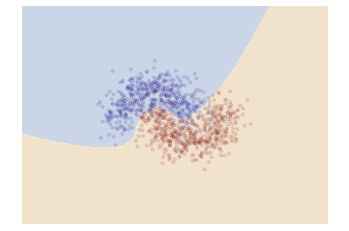

In [20]:
def K(x,y):
    return(phi(x).dot(phi(y).T))

svc = svm.SVC(kernel = K)
svc.fit(X, y)

plotf(svc.predict, X)
plotXy(X, y, alpha=0.1, marker = '.')
print('Score = {}   Anzahl Support-Punkte = {}\n'.format(svc.score(X,y), svc.n_support_))

ypred = svc.predict(X)
print(metrics.classification_report(y, ypred))

## Verallgemeinerung auf mehrere Klassen

Der oben beschriebene Zugang kann natürlich auf auf mehrere Klassen verallgemeinert werden.

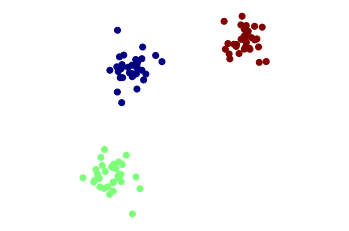

In [21]:
nblob = 3
X,y = make_blobs(n_features=2, centers=nblob, random_state=17)

plotXy(X,y)

1.0

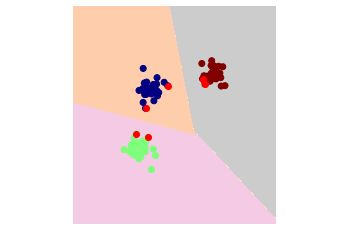

In [22]:
plotXy(X,y)

svc = svm.SVC(C = np.finfo(float).max, kernel = 'linear')
svc.fit(X, y)

plotf(svc.predict, X, nc = svc.n_support_.shape[0])
plotXy(X,y)
plt.plot(*svc.support_vectors_.T, 'ro');

svc.score(X,y)

## Zusammenfassung

- SVC führt auf ein konvexes Optimierungsproblem mit Ungleichheitsnebenbedingungen.

- der Kernel-Trick ist prinzipiell eine Dimensionserhöhung um komplexere Trennflächen zu erzeugen.